<div class="usecase-title"><padding-left: 15px><padding-bottom: 10px><padding-top: 10px>
    <padding-right: 15px>
    <background-color: #Black><p style="color:#14a38e;"><b>Pedestrains Counts and Bus-stops</b></p></div>

<div class="usecase-authors"><b>Authored by: </b>Shilpa Sharma</div>
<div class="usecase-authors"><b>Updated by: </b>Alison Collins</div>

<div class="usecase-duration"><b>Duration:</b> 90 mins</div>

<div class="usecase-level-skill">
    <div class="usecase-level"><b>Level: </b>Intermediate</div>
    <div class="usecase-skill"><b>Pre-requisite Skills: </b>Python, Machine learning, Data Analysis, Github</div>
</div>

<div class="usecase-section-header">Scenario</div>

<b>Imagine the vibrant city of Melbourne grappling with the dual challenges of urban mobility and pedestrian flow. As the city evolves,</b> so does the need for a transit system that not only efficiently moves people but also integrates seamlessly with the bustling pedestrian life. With the growing population, this city needs extensive mode of transportation network for the public; so isn't it important to understand the relationship between the bus-stops and pedestrains counts? 

<b>To address this challenge, a comprehensive study delves into the relationship between bus stops and pedestrian counts. The objective </b> is to understand spatial and temporal patterns, identifying areas where pedestrian activity peaks in conjunction with bus arrivals. This analysis becomes imperative to enhance urban planning, ensuring that the placement and distribution of bus stops align with the ebb and flow of pedestrian traffic. By optimizing this symbiotic relationship, the scenario aims to create a more seamless and efficient urban environment, improving both public transportation and the pedestrian experience in the heart of Melbourne.

<div class="usecase-section-header">What this use case will teach you</div>

At the end of this use case you will:
- Mastered how to import/export open data using API.
- Import libraries, check for missing /null values in order to have a clean dataset.
- Data visualisation by using matplotlib, seaborn, geopanda.
- histograms, coeffiecient matrix, temporal patterns etc.
- Explaining the code by using the dashboards in order make it understandable for either technical or non-technical stakeholders.

<div class="usecase-section-header">Initiation</div>

<b>Navigating the intricate dance between public transportation and pedestrian activity is a critical endeavor in the urban orchestration of a city like Melbourne. The synergy </b> between bus stops and pedestrian thoroughfares is not merely an infrastructural concern but a key determinant of urban vitality and accessibility. In the heart of Melbourne's bustling urban canvas, this initiative aims to delve into the interplay of spatial and temporal dynamics surrounding bus stops and pedestrian counts.

<b>By conducting a meticulous analysis, we endeavor to unravel the patterns that govern the ebb and flow of movement, thereby providing valuable insights</b> for city planners. In our pursuit, we will harness datasets that pinpoint the geographic coordinates of bus stops and capture the pulse of pedestrian activity. For a holistic perspective, we remain adaptable, considering diverse data sources beyond the client's open data portal. This exploration, rooted in the essence of Melbourne's urban spirit, seeks to pave the way for a cityscape where the symbiosis between public transit and pedestrian life is finely tuned, fostering an urban environment that seamlessly integrates mobility with the rhythm of daily life.

IMPORT DATASETS

In [1]:
# Dependencies
import warnings
warnings.filterwarnings("ignore")

import requests
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
from io import StringIO

import time 
import matplotlib.pyplot as plt
import seaborn as sns
import json
import geopandas as gpd
import folium
from folium.plugins import MarkerCluster

In [2]:
#Function to collect data using API v 2.1
def collect_data(dataset_id):
    base_url = 'https://data.melbourne.vic.gov.au/api/explore/v2.1/catalog/datasets/'
    #apikey = api_key #use if use datasets API_key permissions
    dataset_id = dataset_id
    format = 'csv'

    url = f'{base_url}{dataset_id}/exports/{format}'
    params = {
        'select': '*',
        'limit': -1,  # all records
        'lang': 'en',
        'timezone': 'UTC',
        #'api_key': apikey  #use if datasets require API_key permissions
    }

    # GET request
    response = requests.get(url, params=params)

    if response.status_code == 200:
        # StringIO to read the CSV data
        url_content = response.content.decode('utf-8')
        dataset = pd.read_csv(StringIO(url_content), delimiter=';')
        return dataset
    else:
        print(f'Request failed with status code {response.status_code}')

In [3]:
# IMPORT BUS STOPS DATASET
# Set dataset_id to query for the API call dataset name
dataset_id = 'bus-stops'
# Save dataset to df varaible
bus = collect_data(dataset_id)
# Check number of records in df
print(f'The dataset contains {len(bus)} records.')
# View df
bus.head(3)

The dataset contains 309 records.


,geo_point_2d,geo_shape,prop_id,addresspt1,addressp_1,asset_clas,asset_type,objectid,str_id,addresspt,asset_subt,model_desc,mcc_id,roadseg_id,descriptio,model_no
0,"-37.80384165792465, 144.93239283833262","{""coordinates"": [144.93239283833262, -37.80384...",0,76.819824,357,Signage,Sign - Public Transport,355,1235255,570648,NaN,Sign - Public Transport 1 Panel,1235255,21673,Sign - Public Transport 1 Panel Bus Stop Type 13,P.16
1,"-37.81548699581418, 144.9581794249902","{""coordinates"": [144.9581794249902, -37.815486...",0,21.561304,83,Signage,Sign - Public Transport,600,1231226,548056,NaN,Sign - Public Transport 1 Panel,1231226,20184,Sign - Public Transport 1 Panel Bus Stop Type 8,P.16
2,"-37.81353897396532, 144.95728334230756","{""coordinates"": [144.95728334230756, -37.81353...",0,42.177187,207,Signage,Sign - Public Transport,640,1237092,543382,NaN,Sign - Public Transport 1 Panel,1237092,20186,Sign - Public Transport 1 Panel Bus Stop Type 8,P.16


In [4]:
# IMPORT PEDESTRIAN COUNTING DATASET
# Set dataset_id to query for the API call dataset name
dataset_id = 'pedestrian-counting-system-monthly-counts-per-hour'
# Save dataset to df varaible
ped = collect_data(dataset_id)
# Check number of records in df
print(f'The dataset contains {len(ped)} records.')
# View df
ped.head(3)

The dataset contains 549976 records.


,sensor_name,timestamp,locationid,direction_1,direction_2,total_of_directions,location
0,SprFli_T,2023-04-24T21:00:00+00:00,75,36,17,53,"-37.81515276, 144.97467661"
1,SprFli_T,2023-04-25T00:00:00+00:00,75,28,50,78,"-37.81515276, 144.97467661"
2,SprFli_T,2023-04-25T01:00:00+00:00,75,63,63,126,"-37.81515276, 144.97467661"


DATASET PREPROCESSING

In [5]:
# BUS STOP DATA
# Check for NaN Values in Bus-stop Data
print("\033[1mNaN Value in Bus-stop Data:\033[0m")
print(bus.isna().sum())

# Print column names and data types
print("\033[1m\nData Types in Bus-stop Data:\033[0m")
print(bus.dtypes)

# Check for Unique Values in Bus-stop Data
print("\033[1m\nUnique Value in Bus-stop Data:\033[0m")
for column in bus.columns:
    # Exclude columns with non-hashable types from unique value check
    if bus[column].dtype != 'O':
        print(f"{column}: {bus[column].nunique()} unique values")


NaN Value in Bus-stop Data:
geo_point_2d      0
geo_shape         0
prop_id           0
addresspt1        0
addressp_1        0
asset_clas        0
asset_type        0
objectid          0
str_id            0
addresspt         0
asset_subt      309
model_desc        0
mcc_id            0
roadseg_id        0
descriptio        0
model_no          0
dtype: int64

Data Types in Bus-stop Data:
geo_point_2d     object
geo_shape        object
prop_id           int64
addresspt1      float64
addressp_1        int64
asset_clas       object
asset_type       object
objectid          int64
str_id            int64
addresspt         int64
asset_subt      float64
model_desc       object
mcc_id            int64
roadseg_id        int64
descriptio       object
model_no         object
dtype: object

Unique Value in Bus-stop Data:
prop_id: 6 unique values
addresspt1: 274 unique values
addressp_1: 193 unique values
objectid: 309 unique values
str_id: 309 unique values
addresspt: 241 unique values
asset_subt:

The column asset_sub in the bus data contains NaN values, so delete this column.

In [6]:
# Drop the asset_subt column from the bus data, save back to bus variable
bus = bus.drop("asset_subt", axis=1)

In [7]:
# PEDESTRIAN COUNT DATA
# Check for NaN Values in Pedestrian Count Data
print("\033[1m\nNaN Values in Pedestrian Count Data:\033[0m")
print(ped.isna().sum())

# Check for Unique Values in Pedestrian Count Data
print("\033[1m\nUnique Value in Pedestrian Count Data:\033[0m")
for column in ped.columns:
    print(f"{column}: {ped[column].nunique()} unique values")


NaN Values in Pedestrian Count Data:
sensor_name            0
timestamp              0
locationid             0
direction_1            0
direction_2            0
total_of_directions    0
location               0
dtype: int64

Unique Value in Pedestrian Count Data:
sensor_name: 93 unique values
timestamp: 7515 unique values
locationid: 93 unique values
direction_1: 2750 unique values
direction_2: 2662 unique values
total_of_directions: 4456 unique values
location: 92 unique values


EXPLORATORY DATA ANALYSIS

Exploratory Data Analysis will be used to gain insights into the datasets.

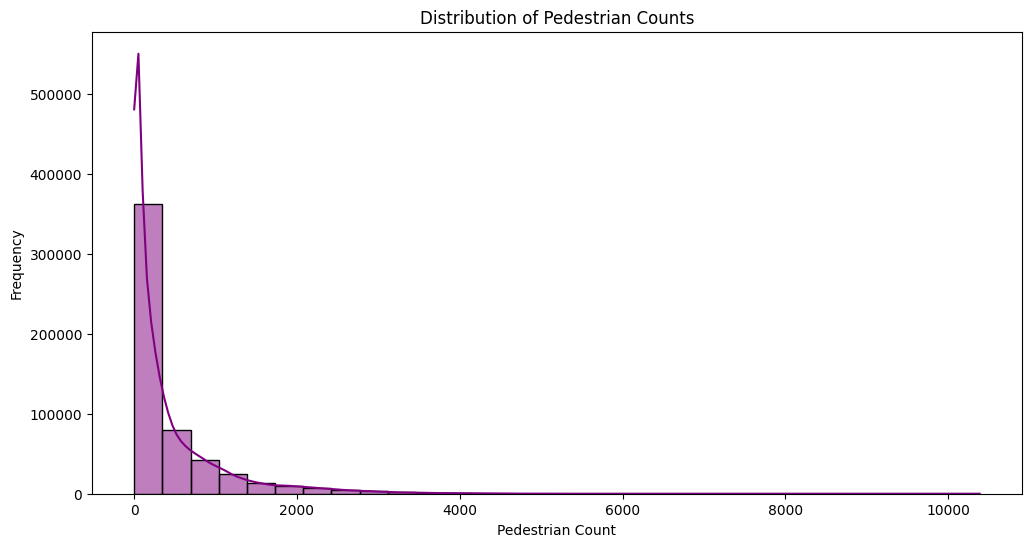

In [8]:
# Plot the distribution of pedestrian counts
plt.figure(figsize=(12, 6))
sns.histplot(ped['total_of_directions'], bins=30, kde=True, color='purple')
plt.title('Distribution of Pedestrian Counts')
plt.xlabel('Pedestrian Count')
plt.ylabel('Frequency')
plt.show()

The distribution of pedestrian counts shows how often each number of pedestrians is seen. This shows that very often less thann two hundred pedestirnas are seen, with few days of more than 2000 pedestrians. The highest pedestrian count is over 10,000.

In [9]:
# Visualization: Bus Stops Map
# Extract latitude and longitude from Geo Shape
bus['coordinates'] = bus['geo_shape'].apply(lambda x: eval(x)['coordinates'])
bus[['Longitude', 'Latitude']] = pd.DataFrame(bus['coordinates'].tolist(), index=bus.index)

# Create a GeoDataFrame
gdf_bus = gpd.GeoDataFrame(bus, geometry=gpd.points_from_xy(bus['Longitude'], bus['Latitude']))
gdf_bus.head(3)

,geo_point_2d,geo_shape,prop_id,addresspt1,addressp_1,asset_clas,asset_type,objectid,str_id,addresspt,model_desc,mcc_id,roadseg_id,descriptio,model_no,coordinates,Longitude,Latitude,geometry
0,"-37.80384165792465, 144.93239283833262","{""coordinates"": [144.93239283833262, -37.80384...",0,76.819824,357,Signage,Sign - Public Transport,355,1235255,570648,Sign - Public Transport 1 Panel,1235255,21673,Sign - Public Transport 1 Panel Bus Stop Type 13,P.16,"[144.93239283833262, -37.80384165792465]",144.932393,-37.803842,POINT (144.93239 -37.80384)
1,"-37.81548699581418, 144.9581794249902","{""coordinates"": [144.9581794249902, -37.815486...",0,21.561304,83,Signage,Sign - Public Transport,600,1231226,548056,Sign - Public Transport 1 Panel,1231226,20184,Sign - Public Transport 1 Panel Bus Stop Type 8,P.16,"[144.9581794249902, -37.81548699581418]",144.958179,-37.815487,POINT (144.95818 -37.81549)
2,"-37.81353897396532, 144.95728334230756","{""coordinates"": [144.95728334230756, -37.81353...",0,42.177187,207,Signage,Sign - Public Transport,640,1237092,543382,Sign - Public Transport 1 Panel,1237092,20186,Sign - Public Transport 1 Panel Bus Stop Type 8,P.16,"[144.95728334230756, -37.81353897396532]",144.957283,-37.813539,POINT (144.95728 -37.81354)


#Explore Temporal patterns in Pedestrains count

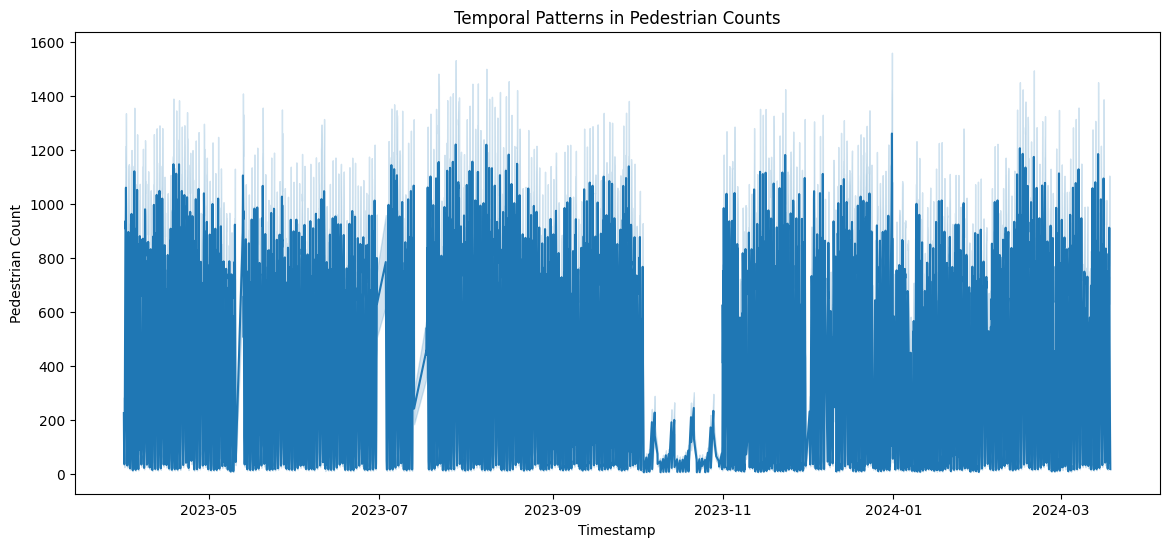

In [12]:
# COnvert the SensingDateTime(Hour) to datetime type data
ped['timestamp'] = pd.to_datetime(ped['timestamp'], utc=True)

# Plot temporal patterns in pedestrian counts
plt.figure(figsize=(14, 6))
sns.lineplot(x='timestamp', y='total_of_directions', data=ped)
plt.title('Temporal Patterns in Pedestrian Counts')
plt.xlabel('Timestamp')
plt.ylabel('Pedestrian Count')
plt.show()


The Temporal pattern in pedestrian data ilustrates pedestrian numbers per hour in the Melbourne area. There are obvious gaps and low points in this data. From the nan analysis above, there are no missing values in this dataset. Further investigation of teh cuase of these gaps will need to be carried out.

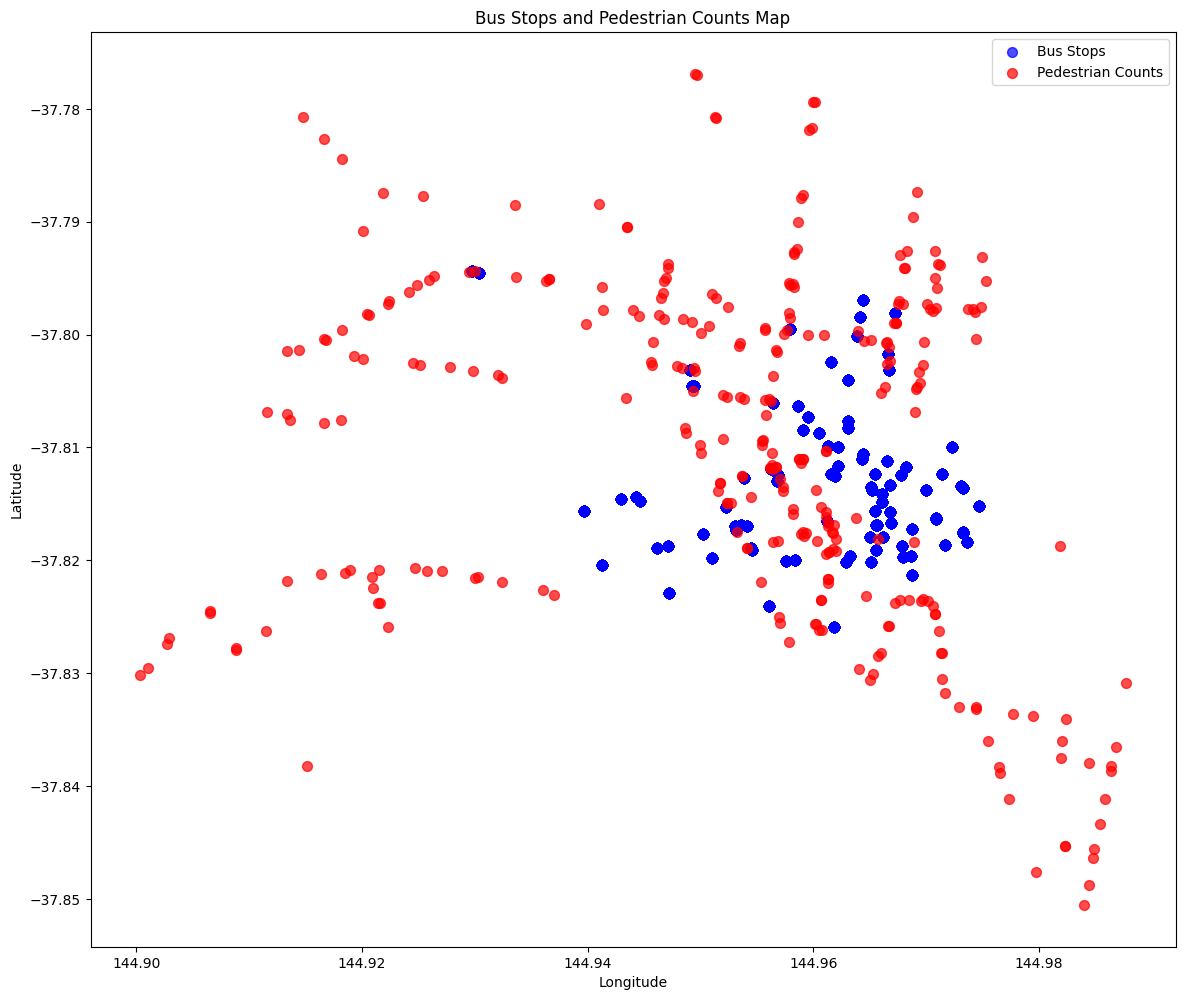

In [15]:
# Split "Location" column into "Latitude" and "Longitude" for pedestrian counts
ped[['Latitude', 'Longitude']] = ped['location'].str.split(', ', expand=True).astype(float)
gdf_ped = gpd.GeoDataFrame(ped, geometry=gpd.points_from_xy(ped['Longitude'], ped['Latitude']))

# Plotting locations of pedestrian counts and bus stops
fig, ax = plt.subplots(figsize=(14, 14))
gdf_ped.plot(ax=ax, color='blue', label='Bus Stops', markersize=50, alpha=0.7)
gdf_bus.plot(ax=ax, color='red', label='Pedestrian Counts', markersize=50, alpha=0.7)

# Customize the plot
ax.set_title('Bus Stops and Pedestrian Counts Map')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.legend()

plt.show()

Created a map by merging both datasets.

In [ ]:
# Create a folium map centered around the mean coordinates of the bus stops
map_center = [gdf_bus['Latitude'].mean(), gdf_bus['Longitude'].mean()]
mymap = folium.Map(location=map_center, zoom_start=14)

# Add bus stops to the map
for index, row in gdf_bus.iterrows():
    folium.Marker(location=[row['Latitude'], row['Longitude']], popup=row['descriptio']).add_to(mymap)

# Add pedestrian counts to the map
marker_cluster = MarkerCluster().add_to(mymap)
for index, row in gdf_ped.iterrows():
    folium.Marker(location=[row['Latitude'], row['Longitude']], popup=row['Sensor_Name']).add_to(marker_cluster)

# Display the map
mymap

References:

https://data.melbourne.vic.gov.au/explore/dataset/pedestrian-counting-system-monthly-counts-per-hour/export/?sort=timestamp

https://data.melbourne.vic.gov.au/explore/dataset/bus-stops/export/

https://www.w3schools.com/python/pandas/default.asp

https://python-visualization.github.io/folium/latest/